# Human-evaluation

In [4]:
# ============================================================
# STEP 1 — Setup: imports, project paths, and input checks
# ============================================================

import ast
import json
import re
import textwrap
from pathlib import Path

import numpy as np
import pandas as pd


def find_project_root(start: Path) -> Path:
    """
    Find the repository root by walking upward until both
    'primary/' and 'derivative/' directories are found.
    """
    cur = start.resolve()
    for _ in range(25):
        if (cur / "primary").is_dir() and (cur / "derivative").is_dir():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise RuntimeError(
        "Project root not found. Expected folders 'primary/' and 'derivative/' "
        "to exist above the current working directory."
    )


ROOT = find_project_root(Path.cwd())

PRIMARY_DIR = ROOT / "primary" / "human-evaluation"
DERIV_DIR   = ROOT / "derivative" / "human-evaluation"
FIG_DIR     = DERIV_DIR / "figures"
TAB_DIR     = DERIV_DIR / "tables"

EVAL_FILE = PRIMARY_DIR / "data-1760978361180.csv"
BG_FILE   = PRIMARY_DIR / "data-1760978508376.csv"

DERIV_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

print(f"ROOT       : {ROOT}")
print(f"PRIMARY_DIR: {PRIMARY_DIR}")
print(f"DERIV_DIR  : {DERIV_DIR}")
print(f"EVAL_FILE  : exists={EVAL_FILE.exists()}  path={EVAL_FILE}")
print(f"BG_FILE    : exists={BG_FILE.exists()}    path={BG_FILE}")

if not EVAL_FILE.exists():
    raise FileNotFoundError(f"Missing evaluation file: {EVAL_FILE}")
if not BG_FILE.exists():
    raise FileNotFoundError(f"Missing background file: {BG_FILE}")

print("Step 1 OK")


ROOT       : C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code
PRIMARY_DIR: C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code\primary\human-evaluation
DERIV_DIR  : C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code\derivative\human-evaluation
EVAL_FILE  : exists=True  path=C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code\primary\human-evaluation\data-1760978361180.csv
BG_FILE    : exists=True    path=C:\Users\Nahid\nih-dmp-llm-evaluation-paper-code\primary\human-evaluation\data-1760978508376.csv
Step 1 OK


In [5]:
# ============================================================
# STEP 2 — Load CSVs and filter background to evaluators
# ============================================================

eval_df = pd.read_csv(EVAL_FILE)
bg_df   = pd.read_csv(BG_FILE)

print(f"Evaluation file: rows={len(eval_df)} cols={len(eval_df.columns)}")
print(f"Background file: rows={len(bg_df)} cols={len(bg_df.columns)}")

required_eval_cols = {
    "participantId",
    "dmpName",
    "evaluations",
    "overallAuthorshipGuess",
    "overallSatisfaction",
}
missing_eval_cols = sorted(required_eval_cols - set(eval_df.columns))
if missing_eval_cols:
    raise KeyError(f"Evaluation CSV missing required columns: {missing_eval_cols}")

if "participantId" not in bg_df.columns:
    raise KeyError(
        "Background CSV missing required column: 'participantId'. "
        f"Available columns: {list(bg_df.columns)}"
    )

eval_df["participantId"] = eval_df["participantId"].astype("string")
bg_df["participantId"]   = bg_df["participantId"].astype("string")

eval_participants = eval_df["participantId"].dropna().unique()
bg_filt = (
    bg_df.dropna(subset=["participantId"])
         .loc[bg_df["participantId"].isin(eval_participants)]
         .copy()
)

n_eval_participants = int(pd.Series(eval_participants).nunique())
n_bg_participants   = int(bg_filt["participantId"].nunique())

print(f"Unique participants in eval_df: {n_eval_participants}")
print(f"Unique participants in bg_filt: {n_bg_participants}")

bg_filt_path = TAB_DIR / "background_filtered_to_evaluators.csv"
bg_filt.to_csv(bg_filt_path, index=False, encoding="utf-8")
print(f"Saved: {bg_filt_path.as_posix()}")

print("Step 2 OK")

Evaluation file: rows=63 cols=6
Background file: rows=26 cols=15
Unique participants in eval_df: 21
Unique participants in bg_filt: 21
Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/background_filtered_to_evaluators.csv
Step 2 OK


In [6]:
# ============================================================
# STEP 3 — Normalize dmpName and add model label
# ============================================================

PREFIX_TO_MODEL = {"X": "Llama", "Y": "GPT", "Z": "Human"}
CODED_PATTERN = re.compile(r"^([XYZ])_(\d+)$", flags=re.IGNORECASE)

def normalize_dmp_name(x):
    """
    Convert coded names like 'X_3', 'y_12', 'Z_1' into:
      - Llama_3
      - GPT_12
      - Human_1
    Leave other formats unchanged.
    """
    if pd.isna(x):
        return x
    s = str(x).strip()
    m = CODED_PATTERN.fullmatch(s)
    if m:
        prefix = m.group(1).upper()
        idx = m.group(2)
        return f"{PREFIX_TO_MODEL[prefix]}_{idx}"
    return s

def extract_model(dmp_name):
    """
    Derive model group from normalized dmpName.
    Expected pattern: <Model>_<id>
    """
    if pd.isna(dmp_name):
        return "Unknown"
    head = str(dmp_name).split("_", 1)[0].strip().lower()
    if head == "gpt":
        return "GPT"
    if head == "llama":
        return "Llama"
    if head == "human":
        return "Human"
    return "Unknown"

eval_clean = eval_df.copy()

before = eval_clean["dmpName"].astype("string")
eval_clean["dmpName"] = eval_clean["dmpName"].apply(normalize_dmp_name)
after = eval_clean["dmpName"].astype("string")

n_normalized = int((before != after).sum(skipna=True))
print(f"dmpName normalized rows: {n_normalized}")

eval_clean["model"] = eval_clean["dmpName"].apply(extract_model)

print("Model counts:")
print(eval_clean["model"].value_counts(dropna=False))

eval_clean_path = TAB_DIR / "human_eval_cleaned.csv"
eval_clean.to_csv(eval_clean_path, index=False, encoding="utf-8")
print(f"Saved: {eval_clean_path.as_posix()}")

print("Step 3 OK")


dmpName normalized rows: 63
Model counts:
model
GPT      21
Llama    21
Human    21
Name: count, dtype: int64
Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/human_eval_cleaned.csv
Step 3 OK


In [7]:
# ============================================================
# STEP 4 — Expand evaluations into an element-level long table
# ============================================================

def parse_list_of_dicts(raw):
    """
    Parse the 'evaluations' field into a list of dicts.
    Supports:
      - list already
      - JSON string
      - Python literal string (ast.literal_eval)
    Returns [] on failure.
    """
    if isinstance(raw, list):
        return raw
    if raw is None or (isinstance(raw, float) and pd.isna(raw)):
        return []
    if not isinstance(raw, str) or not raw.strip():
        return []

    s = raw.strip()

    try:
        obj = json.loads(s)
        return obj if isinstance(obj, list) else []
    except Exception:
        pass

    s2 = re.sub(r"\.\.\.\s*$", "", s).strip()
    try:
        obj = json.loads(s2)
        return obj if isinstance(obj, list) else []
    except Exception:
        pass

    try:
        obj = ast.literal_eval(s2)
        return obj if isinstance(obj, list) else []
    except Exception:
        return []

rows = []
bad_parse = []

for _, r in eval_clean.iterrows():
    raw_eval = r.get("evaluations", None)
    items = parse_list_of_dicts(raw_eval)

    if isinstance(raw_eval, str) and raw_eval.strip() and not items:
        bad_parse.append({
            "id": r.get("id"),
            "participantId": r.get("participantId"),
            "dmpName": r.get("dmpName"),
        })

    for it in items:
        if not isinstance(it, dict):
            continue

        selected_errors = it.get("selectedErrors", [])
        if selected_errors is None:
            selected_errors = []
        if not isinstance(selected_errors, list):
            selected_errors = [selected_errors]

        rows.append({
            "id": r.get("id"),
            "participantId": r.get("participantId"),
            "dmpName": r.get("dmpName"),
            "model": r.get("model"),
            "overallAuthorshipGuess": r.get("overallAuthorshipGuess"),
            "overallSatisfaction": r.get("overallSatisfaction"),
            "elementTitle": it.get("elementTitle"),
            "selectedErrors": selected_errors,
            "satisfactionScore": it.get("satisfactionScore"),
            "additionalComments": it.get("additionalComments", ""),
        })

expanded = pd.DataFrame(rows)

print(f"Expanded rows: {len(expanded)}")
print(f"Rows with non-empty evaluations but parse failure: {len(bad_parse)}")

expanded_path = TAB_DIR / "expanded_evaluations.csv"
expanded.to_csv(expanded_path, index=False, encoding="utf-8")
print(f"Saved: {expanded_path.as_posix()}")

bad_parse_df = pd.DataFrame(bad_parse)
bad_parse_path = TAB_DIR / "expanded_evaluations_parse_failures.csv"
bad_parse_df.to_csv(bad_parse_path, index=False, encoding="utf-8")
print(f"Saved: {bad_parse_path.as_posix()}")

print("Step 4 OK")

Expanded rows: 378
Rows with non-empty evaluations but parse failure: 0
Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/expanded_evaluations.csv
Saved: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/expanded_evaluations_parse_failures.csv
Step 4 OK


In [8]:
# ============================================================
# STEP 4A — Duplicate checks for expanded evaluations
# ============================================================

import json

# Ensure output directory exists
TAB_DIR.mkdir(parents=True, exist_ok=True)

required_cols = {"participantId", "dmpName", "elementTitle"}
missing = sorted(required_cols - set(expanded.columns))
if missing:
    raise KeyError(f"Expanded table missing required columns for duplicate checks: {missing}")

# Ensure consistent types for key columns
expanded["participantId"] = expanded["participantId"].astype("string")
expanded["dmpName"] = expanded["dmpName"].astype("string")
expanded["elementTitle"] = expanded["elementTitle"].astype("string")

# Optional: treat missing element titles as a stable placeholder
expanded["elementTitle"] = expanded["elementTitle"].fillna("MISSING_ELEMENT_TITLE")

key_cols = ["participantId", "dmpName", "elementTitle"]

# ------------------------------------------------------------
# 1) Key-level duplicates (recommended check)
# ------------------------------------------------------------
key_dup_mask = expanded.duplicated(subset=key_cols, keep=False)
n_key_dups = int(key_dup_mask.sum())

print(f"Expanded rows: {len(expanded)}")
print(f"Duplicate element keys {key_cols}: {n_key_dups}")

if n_key_dups > 0:
    key_dups_path = TAB_DIR / "expanded_key_duplicates.csv"
    expanded.loc[key_dup_mask].sort_values(key_cols).to_csv(
        key_dups_path, index=False, encoding="utf-8"
    )
    print(f"Saved key duplicates: {key_dups_path.as_posix()}")

# ------------------------------------------------------------
# 2) Exact duplicates across all columns (list/dict-safe)
# ------------------------------------------------------------
hashable = expanded.copy()

def to_hashable(x):
    if isinstance(x, (list, dict)):
        return json.dumps(x, sort_keys=True, ensure_ascii=False)
    return x

obj_cols = hashable.select_dtypes(include=["object", "string"]).columns
for c in obj_cols:
    hashable[c] = hashable[c].apply(to_hashable)

exact_dup_mask = hashable.duplicated(keep=False)
n_exact_dups = int(exact_dup_mask.sum())

print(f"Exact duplicate rows (all columns, list/dict-safe): {n_exact_dups}")

if n_exact_dups > 0:
    exact_dups_path = TAB_DIR / "expanded_exact_duplicates.csv"
    expanded.loc[exact_dup_mask].sort_values(key_cols).to_csv(
        exact_dups_path, index=False, encoding="utf-8"
    )
    print(f"Saved exact duplicates: {exact_dups_path.as_posix()}")

# ------------------------------------------------------------
# Conclusion
# ------------------------------------------------------------
if n_key_dups == 0 and n_exact_dups == 0:
    print("Step 4A OK: No duplicates detected in expanded evaluations.")
else:
    print("Step 4A completed: Duplicates detected. See saved CSV files for inspection.")

Expanded rows: 378
Duplicate element keys ['participantId', 'dmpName', 'elementTitle']: 0
Exact duplicate rows (all columns, list/dict-safe): 0
Step 4A OK: No duplicates detected in expanded evaluations.


In [9]:
# ============================================================
# STEP 5 — Satisfaction tables (overall + element-level ordinal)
# ============================================================

expanded2 = expanded.copy()

# Overall satisfaction: deduplicate at participantId + dmpName level
expanded2["participantId"] = expanded2["participantId"].astype("string")
expanded2["dmpName"] = expanded2["dmpName"].astype("string")

overall_unit = expanded2.drop_duplicates(subset=["participantId", "dmpName"]).copy()
overall_unit["overallSatisfaction"] = pd.to_numeric(overall_unit["overallSatisfaction"], errors="coerce")
overall_unit = overall_unit[overall_unit["overallSatisfaction"].between(1, 5)].copy()

desired_models = ["Human", "Llama", "GPT"]
overall_unit = overall_unit[overall_unit["model"].isin(desired_models)].copy()

print(f"Overall satisfaction valid rows: {len(overall_unit)}")

counts_tbl = (
    overall_unit.groupby(["model", "overallSatisfaction"])
                .size()
                .unstack(fill_value=0)
                .reindex(columns=[1, 2, 3, 4, 5], fill_value=0)
                .reindex(desired_models)
)

row_totals = counts_tbl.sum(axis=1).replace(0, np.nan)
perc_tbl = (counts_tbl.div(row_totals, axis=0) * 100).fillna(0).round(1)

summary_tbl = (
    overall_unit.groupby("model")["overallSatisfaction"]
                .agg(N="count", mean="mean", std="std", median="median", min="min", max="max")
                .reindex(desired_models)
                .round({"mean": 3, "std": 3, "median": 3})
)

# Element-level satisfaction mapping
sat_map = {
    "very dissatisfied": 1,
    "dissatisfied": 2,
    "neither dissatisfied or satisfied": 3,
    "satisfied": 4,
    "very satisfied": 5,
}

s = expanded2["satisfactionScore"].astype("string").str.strip().str.lower()
expanded2["satisfactionOrdinal"] = s.map(sat_map)

elem_ok = expanded2["satisfactionOrdinal"].between(1, 5) & expanded2["model"].isin(desired_models)
element_unit = expanded2.loc[elem_ok, ["model", "elementTitle", "satisfactionOrdinal"]].copy()

print(f"Element satisfaction mapped rows: {len(element_unit)}")

elem_counts_tbl = (
    element_unit.groupby(["model", "satisfactionOrdinal"])
                .size()
                .unstack(fill_value=0)
                .reindex(columns=[1, 2, 3, 4, 5], fill_value=0)
                .reindex(desired_models)
)

# Save outputs
counts_path = TAB_DIR / "overall_satisfaction_counts_by_model.csv"
perc_path   = TAB_DIR / "overall_satisfaction_percent_by_model.csv"
summ_path   = TAB_DIR / "overall_satisfaction_summary_by_model.csv"
elem_path   = TAB_DIR / "element_satisfaction_counts_by_model.csv"

counts_tbl.to_csv(counts_path, encoding="utf-8")
perc_tbl.to_csv(perc_path, encoding="utf-8")
summary_tbl.to_csv(summ_path, encoding="utf-8")
elem_counts_tbl.to_csv(elem_path, encoding="utf-8")

print("Saved:")
print(f" - {counts_path.as_posix()}")
print(f" - {perc_path.as_posix()}")
print(f" - {summ_path.as_posix()}")
print(f" - {elem_path.as_posix()}")

print("Step 5 OK")

Overall satisfaction valid rows: 63
Element satisfaction mapped rows: 377
Saved:
 - C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/overall_satisfaction_counts_by_model.csv
 - C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/overall_satisfaction_percent_by_model.csv
 - C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/overall_satisfaction_summary_by_model.csv
 - C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/element_satisfaction_counts_by_model.csv
Step 5 OK


C:\Users\Nahid\AppData\Local\Temp\ipykernel_23796\1564816498.py:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")


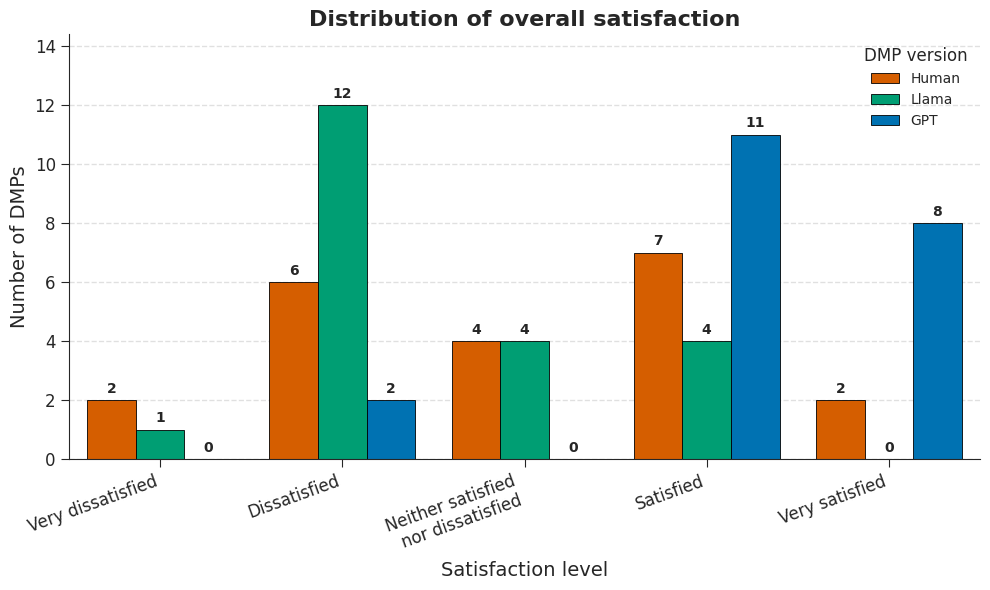

Saved figure: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/figures/overall_satisfaction_by_group.png
Step 5A OK


In [10]:
# ============================================================
# STEP 5A — Figure: Overall satisfaction distribution by model
#           (saves to derivative/human-evaluation/figures)
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure output directories exist
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

# ---------- Seaborn styling ----------
sns.set(
    style="ticks",
    font="DejaVu Sans",
    rc={
        "font.size": 10,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 10,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out",
        "ytick.direction": "out",
    },
)

# Wong palette (color-blind friendly)
wong = {
    "Green": "#009E73",
    "Blue": "#0072B2",
    "Vermillion": "#D55E00",
}

# Model order and colors
model_order = ["Human", "Llama", "GPT"]
group_to_color = {
    "Human": wong["Vermillion"],
    "Llama": wong["Green"],
    "GPT": wong["Blue"],
}
palette_list = [group_to_color[m] for m in model_order]

# ---------- Preprocess ----------
df_plot = expanded.copy()

required_cols = {"participantId", "dmpName", "model", "overallSatisfaction"}
missing = sorted(required_cols - set(df_plot.columns))
if missing:
    raise KeyError(f"Missing required columns for Step 5B plot: {missing}")

# One overall satisfaction per participantId + dmpName
df_plot["participantId"] = df_plot["participantId"].astype("string")
df_plot["dmpName"] = df_plot["dmpName"].astype("string")
df_plot = df_plot.drop_duplicates(subset=["participantId", "dmpName"]).copy()

# Keep only expected groups
df_plot = df_plot[df_plot["model"].isin(model_order)].copy()
df_plot["DMP version"] = df_plot["model"]

# Clean satisfaction to numeric 1..5
df_plot["overallSatisfaction"] = pd.to_numeric(df_plot["overallSatisfaction"], errors="coerce")
df_plot = df_plot[df_plot["overallSatisfaction"].between(1, 5)].copy()
df_plot["overallSatisfaction"] = df_plot["overallSatisfaction"].astype(int)

# Satisfaction labels
score_to_label = {
    1: "Very dissatisfied",
    2: "Dissatisfied",
    3: "Neither satisfied\nnor dissatisfied",
    4: "Satisfied",
    5: "Very satisfied",
}
df_plot["Satisfaction level"] = df_plot["overallSatisfaction"].map(score_to_label)

x_order = [
    "Very dissatisfied",
    "Dissatisfied",
    "Neither satisfied\nnor dissatisfied",
    "Satisfied",
    "Very satisfied",
]

# ---------- Aggregate counts ----------
counts = (
    df_plot.groupby(["Satisfaction level", "DMP version"])
           .size()
           .reset_index(name="Count")
)

all_idx = pd.MultiIndex.from_product(
    [x_order, model_order],
    names=["Satisfaction level", "DMP version"]
)
counts = (
    counts.set_index(["Satisfaction level", "DMP version"])
          .reindex(all_idx, fill_value=0)
          .reset_index()
)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=counts,
    x="Satisfaction level",
    y="Count",
    hue="DMP version",
    order=x_order,
    hue_order=model_order,
    palette=palette_list,
    saturation=1,
    dodge=True,
    edgecolor="black",
    linewidth=0.6,
    ax=ax,
)

for p in ax.patches:
    p.set_alpha(1.0)

ax.set_title("Distribution of overall satisfaction")
ax.set_xlabel("Satisfaction level")
ax.set_ylabel("Number of DMPs")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")

ymax = counts["Count"].max() * 1.20 if len(counts) else 1
ax.set_ylim(0, max(1, ymax))

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=3, fontsize=10, fontweight="bold")

ax.grid(axis="y", linestyle="--", alpha=0.6)
sns.despine(ax=ax)
ax.legend(title="DMP version", frameon=False, loc="upper right")

fig.tight_layout()

fig_path = FIG_DIR / "overall_satisfaction_by_group.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print("Saved figure:", fig_path.as_posix())
print("Step 5A OK")



Authorship guess correctness counts:
is_correct   Guess correct  Guess incorrect
source_norm                                
Human                   14                7
Llama                   15                6
GPT                      3               18
Saved table: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/authorship_guess_correctness_counts.csv


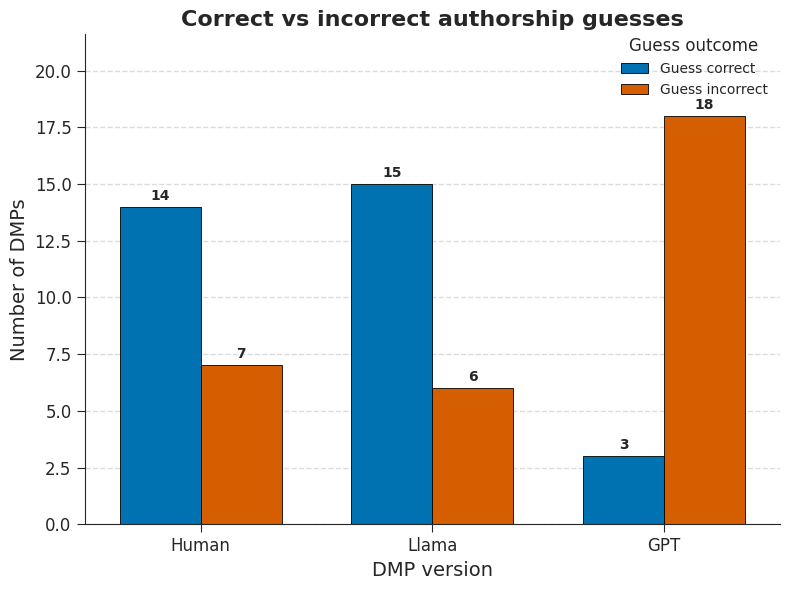

Saved figure: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/figures/authorship_guess_correctness_by_model.png
Step 6 OK


In [11]:
# ============================================================
# STEP 6 — Authorship guess correctness (Human vs LLM)
#           (table + figure saved to derivative/human-evaluation)
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use cleaned evaluation table from Step 3
df = eval_clean.copy()

required_cols = {"dmpName", "overallAuthorshipGuess"}
missing = sorted(required_cols - set(df.columns))
if missing:
    raise KeyError(f"Missing required columns for Step 6: {missing}")

def extract_author_from_dmp(name):
    if pd.isna(name):
        return None
    s = str(name).strip().lower()
    if s.startswith("llama"):
        return "Llama"
    if s.startswith("gpt"):
        return "GPT"
    if s.startswith("human"):
        return "Human"
    return None

def expected_group_from_source(src):
    if src in ("Llama", "GPT"):
        return "llm"
    if src == "Human":
        return "human"
    return None

def normalize_guess(g):
    """
    Map free-text guess to {'llm','human'} if possible, else None.
    Keeps the logic simple but avoids losing common entries.
    """
    if not isinstance(g, str):
        return None
    s = g.strip().lower()
    if "human" in s:
        return "human"
    if ("llm" in s) or ("gpt" in s) or ("chatgpt" in s) or ("llama" in s) or ("ai" in s) or ("model" in s):
        return "llm"
    return None

# Derive columns
df["source"] = df["dmpName"].apply(extract_author_from_dmp)             # {Llama, GPT, Human}
df["expected_group"] = df["source"].apply(expected_group_from_source)   # {llm, human}
df["guess_group"] = df["overallAuthorshipGuess"].apply(normalize_guess) # {llm, human}

# Correctness flag
df["is_correct"] = np.where(
    (df["expected_group"].notna()) &
    (df["guess_group"].notna()) &
    (df["expected_group"] == df["guess_group"]),
    1, 0
)

df2 = df.copy()

# Keep only rows where we could evaluate (both expected and guess are present)
df2 = df2[df2["expected_group"].notna() & df2["guess_group"].notna()].copy()

df2["Guess outcome"] = df2["is_correct"].map({1: "Guess correct", 0: "Guess incorrect"})
df2["source_norm"] = df2["source"]

# Counts table
acc_counts = (
    df2.groupby("source_norm")["is_correct"]
       .value_counts()
       .unstack(fill_value=0)
       .rename(columns={1: "Guess correct", 0: "Guess incorrect"})
)

for col in ["Guess correct", "Guess incorrect"]:
    if col not in acc_counts.columns:
        acc_counts[col] = 0

acc_counts = acc_counts[["Guess correct", "Guess incorrect"]]
acc_counts = acc_counts.reindex([m for m in model_order if m in acc_counts.index])

print("\nAuthorship guess correctness counts:")
print(acc_counts)

# Save table
table_path = TAB_DIR / "authorship_guess_correctness_counts.csv"
acc_counts.to_csv(table_path, encoding="utf-8")
print("Saved table:", table_path.as_posix())

# Prepare plot data
plot_df = (
    acc_counts.reset_index()
              .melt(id_vars="source_norm", var_name="Guess outcome", value_name="Count")
              .rename(columns={"source_norm": "DMP version"})
)

# Plot styling (same as Step 5B)
sns.set(
    style="ticks",
    font="DejaVu Sans",
    rc={
        "font.size": 10,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 10,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out",
        "ytick.direction": "out",
    },
)

hue_order = ["Guess correct", "Guess incorrect"]
palette_list = [wong["Blue"], wong["Vermillion"]]

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=plot_df,
    x="DMP version",
    y="Count",
    hue="Guess outcome",
    order=acc_counts.index.tolist(),
    hue_order=hue_order,
    palette=palette_list,
    saturation=1,
    dodge=True,
    edgecolor="black",
    width=0.70,
    linewidth=0.6,
    ax=ax,
)

for p in ax.patches:
    p.set_alpha(1.0)

ax.set_ylabel("Number of DMPs")
ax.set_xlabel("DMP version")
ax.set_title("Correct vs incorrect authorship guesses")

max_val = plot_df["Count"].max() if len(plot_df) else 1
ax.set_ylim(0, max(1, max_val) * 1.20)

for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=3, fontsize=10, fontweight="bold")

ax.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine(ax=ax)
ax.legend(title="Guess outcome", frameon=False, loc="upper right", bbox_to_anchor=(1.0, 1.02))

fig.tight_layout()

fig_path = FIG_DIR / "authorship_guess_correctness_by_model.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print("Saved figure:", fig_path.as_posix())
print("Step 6 OK")

In [12]:
# ============================================================
# STEP 7 — Element-level error + satisfaction analysis
#          Outputs saved under: derivative/human-evaluation/tables
# ============================================================

import ast
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# Gate: proceed only if expanded has no duplicates
# ------------------------------------------------------------
def assert_no_duplicates(expanded_df: pd.DataFrame, tab_dir: Path) -> None:
    tab_dir.mkdir(parents=True, exist_ok=True)

    required = {"participantId", "dmpName", "elementTitle"}
    missing = sorted(required - set(expanded_df.columns))
    if missing:
        raise KeyError(f"Expanded table missing columns required for duplicate gate: {missing}")

    df = expanded_df.copy()
    df["participantId"] = df["participantId"].astype("string")
    df["dmpName"] = df["dmpName"].astype("string")
    df["elementTitle"] = df["elementTitle"].astype("string").fillna("MISSING_ELEMENT_TITLE")

    key_cols = ["participantId", "dmpName", "elementTitle"]
    key_dup_mask = df.duplicated(subset=key_cols, keep=False)
    n_key_dups = int(key_dup_mask.sum())

    # Exact duplicates across all columns (list/dict-safe)
    hashable = df.copy()

    def to_hashable(x):
        if isinstance(x, (list, dict)):
            return json.dumps(x, sort_keys=True, ensure_ascii=False)
        return x

    obj_cols = hashable.select_dtypes(include=["object", "string"]).columns
    for c in obj_cols:
        hashable[c] = hashable[c].apply(to_hashable)

    exact_dup_mask = hashable.duplicated(keep=False)
    n_exact_dups = int(exact_dup_mask.sum())

    print("Duplicate gate check:")
    print(f" - Key duplicates {key_cols}: {n_key_dups}")
    print(f" - Exact duplicates (all columns): {n_exact_dups}")

    if n_key_dups > 0:
        p = tab_dir / "step7_block_key_duplicates.csv"
        df.loc[key_dup_mask].sort_values(key_cols).to_csv(p, index=False, encoding="utf-8")
        raise RuntimeError(f"STEP 7 blocked: key-level duplicates found. See: {p.as_posix()}")

    if n_exact_dups > 0:
        p = tab_dir / "step7_block_exact_duplicates.csv"
        df.loc[exact_dup_mask].sort_values(key_cols).to_csv(p, index=False, encoding="utf-8")
        raise RuntimeError(f"STEP 7 blocked: exact duplicates found. See: {p.as_posix()}")

    print("Duplicate gate passed: proceeding with Step 7.")


# Ensure base output folders exist (from Step 1)
TAB_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Use the same base folders as your pipeline
STEP7_TAB_DIR = TAB_DIR  # derivative/human-evaluation/tables
STEP7_FIG_DIR = FIG_DIR  # derivative/human-evaluation/figures

# Duplicate gate
assert_no_duplicates(expanded, STEP7_TAB_DIR)


# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------
def make_element_short(s):
    if pd.isna(s):
        return None
    m = re.search(r"(?i)\b(elem(?:ent|n|nt)?)\s*(\d+)", str(s))
    return f"Element {m.group(2)}" if m else None

def element_order_key(x):
    if not isinstance(x, str):
        return 1_000_000
    m = re.search(r"Element\s+(\d+)", x)
    return int(m.group(1)) if m else 1_000_000

def parse_errors(x):
    if isinstance(x, list):
        return x
    if pd.isna(x) or str(x).strip() == "":
        return []
    s = str(x)
    try:
        v = json.loads(s)
        return v if isinstance(v, list) else [str(v)]
    except Exception:
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, list) else [str(v)]
        except Exception:
            return [s]

def clean_error_list(lst):
    keep = []
    for e in lst:
        s = str(e).strip()
        if re.fullmatch(r"(?i)none(\s*--.*)?", s):
            continue
        if re.fullmatch(r"(?i)no\s*errors?\s*seen", s):
            continue
        if s == "":
            continue
        keep.append(s)
    return keep

def simplify_error_label(lbl):
    return str(lbl).split("--", 1)[0].strip()

def extract_model(dmp):
    if pd.isna(dmp):
        return "Unknown"
    s = str(dmp).split("_")[0].strip().lower()
    if s == "gpt":
        return "GPT"
    if s == "llama":
        return "Llama"
    if s == "human":
        return "Human"
    return "Unknown"

def contrast_color(val_pct, cmap, norm):
    r, g, b, _ = cmap(norm(val_pct))
    lum = 0.299 * r + 0.587 * g + 0.114 * b
    return "black" if lum > 0.6 else "white"


# ------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------
work = expanded.copy()

# Create satisfactionOrdinal if missing
if "satisfactionOrdinal" not in work.columns:
    if "satisfactionScore" not in work.columns:
        raise KeyError("Cannot build satisfactionOrdinal: missing 'satisfactionScore' column in expanded.")

    sat_map = {
        "very dissatisfied": 1,
        "dissatisfied": 2,
        "neither dissatisfied or satisfied": 3,
        "satisfied": 4,
        "very satisfied": 5,
    }

    work["satisfactionOrdinal"] = (
        work["satisfactionScore"]
        .astype("string")
        .str.strip()
        .str.lower()
        .map(sat_map)
    )

    mapped_n = int(work["satisfactionOrdinal"].notna().sum())
    print(f"Created satisfactionOrdinal from satisfactionScore (mapped rows: {mapped_n} / {len(work)})")

work["elementShort"] = work["elementTitle"].apply(make_element_short)
work["parsedErrors"] = work["selectedErrors"].apply(parse_errors).apply(clean_error_list)
work["model"] = work["dmpName"].apply(extract_model)

model_types = ["GPT", "Llama", "Human"]


# ------------------------------------------------------------
# Per-model outputs
# ------------------------------------------------------------
for model in model_types:
    print(f"\nMODEL: {model}")
    df_model = work[work["model"] == model].copy()

    # Explode errors
    err_exp = (
        df_model
        .explode("parsedErrors")
        .assign(errorSimple=lambda d: d["parsedErrors"].fillna("").astype(str).map(simplify_error_label))
    )
    err_exp = err_exp[
        err_exp["errorSimple"].str.strip().ne("") &
        err_exp["errorSimple"].str.lower().ne("none")
    ]

    # Error counts
    error_counts = (
        err_exp
        .groupby(["elementShort", "errorSimple"], dropna=False)
        .size()
        .reset_index(name="count")
    )
    error_counts["__ord"] = error_counts["elementShort"].map(element_order_key)
    error_counts = error_counts.sort_values(["__ord", "count"], ascending=[True, False]).drop(columns="__ord")
    error_counts.to_csv(STEP7_TAB_DIR / f"error_counts_{model}.csv", index=False, encoding="utf-8")

    # Error matrix
    error_matrix = (
        error_counts
        .pivot(index="errorSimple", columns="elementShort", values="count")
        .fillna(0)
        .astype(int)
    )
    if len(error_matrix.columns) > 0:
        error_matrix = error_matrix[sorted(error_matrix.columns, key=element_order_key)]
    error_matrix = error_matrix.sort_index()
    error_matrix.to_csv(STEP7_TAB_DIR / f"error_matrix_{model}.csv", encoding="utf-8")

    # Satisfaction stats
    sat_stats = (
        df_model
        .dropna(subset=["elementShort", "satisfactionOrdinal"])
        .groupby("elementShort", as_index=False)["satisfactionOrdinal"]
        .agg(mean="mean", std="std", n="count", median="median")
    )
    sat_stats["__ord"] = sat_stats["elementShort"].map(element_order_key)
    sat_stats = sat_stats.sort_values("__ord").drop(columns="__ord").reset_index(drop=True)
    sat_stats.to_csv(STEP7_TAB_DIR / f"satisfaction_stats_{model}.csv", index=False, encoding="utf-8")

    # Summary with top 3 errors
    top_errors = (
        error_counts
        .groupby("elementShort", as_index=False)
        .apply(lambda g: ", ".join(g.sort_values("count", ascending=False).head(3)["errorSimple"].tolist()))
        .reset_index(drop=True)
        .rename(columns={0: "topErrors"})
    )
    summary = sat_stats.merge(top_errors, on="elementShort", how="left")
    summary.to_csv(STEP7_TAB_DIR / f"element_summary_{model}.csv", index=False, encoding="utf-8")

    # Heatmap
    if error_matrix.shape[0] > 0 and error_matrix.shape[1] > 0:
        col_totals = error_matrix.sum(axis=0).replace(0, np.nan)
        pct_matrix = (error_matrix.div(col_totals, axis=1) * 100).fillna(0)

        mask_nonzero = error_matrix.sum(axis=1) > 0
        error_matrix_plot = error_matrix.loc[mask_nonzero]
        pct_matrix_plot = pct_matrix.loc[mask_nonzero]

        plt.figure(figsize=(12, max(6, 0.3 * len(error_matrix_plot.index))))
        im = plt.imshow(pct_matrix_plot.values, aspect="auto", cmap="viridis")
        plt.colorbar(label="Percent of Errors (%)")
        plt.xticks(range(pct_matrix_plot.shape[1]), pct_matrix_plot.columns, rotation=0)
        plt.yticks(range(pct_matrix_plot.shape[0]), error_matrix_plot.index)
        plt.title(f"Error Distribution per Element – {model}")

        cmap = im.get_cmap()
        norm = im.norm
        for r in range(pct_matrix_plot.shape[0]):
            for c in range(pct_matrix_plot.shape[1]):
                cnt = int(error_matrix_plot.iat[r, c])
                if cnt > 0:
                    pct = float(pct_matrix_plot.iat[r, c])
                    txt = f"{pct:.0f}%\n({cnt})"
                    plt.text(c, r, txt, ha="center", va="center", fontsize=8,
                             color=contrast_color(pct, cmap, norm))

        plt.tight_layout()
        plt.savefig(STEP7_FIG_DIR / f"error_percent_heatmap_{model}.png", dpi=150)
        plt.close()


# ------------------------------------------------------------
# Satisfaction comparison table
# ------------------------------------------------------------
element_labels = {
    "Element 1": "Types and Amount of Scientific Data; Data to be Preserved and Shared; Metadata and Documentation",
    "Element 2": "Tools, Software, and Code",
    "Element 3": "Standards",
    "Element 4": "Repository, Findability, and Availability Timeline",
    "Element 5": "Access, Distribution, Reuse, Controlled Access, Privacy, and Confidentiality",
    "Element 6": "Oversight of DMP",
}

all_stats = []
for model in model_types:
    df_stats = pd.read_csv(STEP7_TAB_DIR / f"satisfaction_stats_{model}.csv")
    df_stats["model"] = model
    all_stats.append(df_stats)

df_all = pd.concat(all_stats, ignore_index=True)
df_all["mean_std"] = df_all.apply(lambda r: f"{r['mean']:.1f}±{r['std']:.2f}", axis=1)

table = df_all.pivot(index="elementShort", columns="model", values="mean_std").reset_index()
table.insert(1, "elementField", table["elementShort"].map(element_labels))
table = table.sort_values("elementShort", key=lambda col: col.map(element_order_key))

table.columns.name = None
table = table.rename(columns={
    "elementShort": "elementNumber",
    "Llama": "Llama 3.3",
    "GPT": "GPT 4.1",
    "Human": "Human",
})

final_path = STEP7_TAB_DIR / "satisfaction_comparison_table.csv"
table.to_csv(final_path, index=False, encoding="utf-8")

print("\nSaved Step 7 outputs to:")
print(" - Tables :", STEP7_TAB_DIR.as_posix())
print(" - Figures:", STEP7_FIG_DIR.as_posix())
print(" - Comparison table:", final_path.as_posix())
print("Step 7 OK")

Duplicate gate check:
 - Key duplicates ['participantId', 'dmpName', 'elementTitle']: 0
 - Exact duplicates (all columns): 0
Duplicate gate passed: proceeding with Step 7.
Created satisfactionOrdinal from satisfactionScore (mapped rows: 377 / 378)

MODEL: GPT

MODEL: Llama


C:\Users\Nahid\AppData\Local\Temp\ipykernel_23796\1169162097.py:237: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ", ".join(g.sort_values("count", ascending=False).head(3)["errorSimple"].tolist()))
C:\Users\Nahid\AppData\Local\Temp\ipykernel_23796\1169162097.py:237: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ", ".join(g.sort_values("count", ascending=False).head(3)["errorSimple"]


MODEL: Human

Saved Step 7 outputs to:
 - Tables : C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables
 - Figures: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/figures
 - Comparison table: C:/Users/Nahid/nih-dmp-llm-evaluation-paper-code/derivative/human-evaluation/tables/satisfaction_comparison_table.csv
Step 7 OK


C:\Users\Nahid\AppData\Local\Temp\ipykernel_23796\1169162097.py:237: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ", ".join(g.sort_values("count", ascending=False).head(3)["errorSimple"].tolist()))
